In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import argparse
qml.QubitStateVector = qml.StatePrep

from variational_lse_solver import VarLSESolver


"""
To run this script you need the following packages:
- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)
- Numpy < 2: need to install something like numpy 1.26.4
- Python 3.12
- torch 2.2.2
"""


'\nTo run this script you need the following packages:\n- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)\n- Numpy < 2: need to install something like numpy 1.26.4\n- Python 3.12\n- torch 2.2.2\n'

To run this you need to change the following in var_lse_solver.py
1. Import the noise model from the noise_model.py file in the top: from noise_model import noise_model
2. Change the function "qnode_evaluate_x" with these things:
    - Change 'default.qubit' to 'default.mixed': dev = qml.device('default.mixed', wires=self.data_qubits) 
        - Changed so we not only use pure states. 
    - Remove/comment out: @qml.qnode(dev, interface='torch')
    - Insert the following after the circuit_evolve_x definition: 
        - circuit_evolve_x = qml.qnode(dev, interface='torch')(circuit_evolve_x)
        - noisy_circuit_evolve_x = qml.add_noise(circuit_evolve_x, noise_model)
        - return noisy_circuit_evolve_x
    

In [2]:

# unitary representation of Paulis
I_ = np.array([[1.0, 0.0], [0.0, 1.0]])
X_ = np.array([[0.0, 1.0], [1.0, 0.0]])
Y_ = np.array([[0.0, -1.j], [1.j, 0.0]])
Z_ = np.array([[1.0, 0.0], [0.0, -1.0]])

a = ["III", "XZI", "XII"]
b = np.ones(8)/np.sqrt(8)



In [3]:
N_runs = 2
local_results = np.zeros([N_runs, len(b)])
global_results = np.zeros([N_runs, len(b)])


for i in range(N_runs):
    lse_local = VarLSESolver(a, 
                b, 
                coeffs=[1.0, 0.2, 0.2], 
                method="hadamard", 
                local=True, 
                lr=0.1, 
                steps=50,
                threshold=0.001, 
                epochs=10) #Epochs: max circuit depth for dynamic circuit

    lse_global = VarLSESolver(a, 
                b, 
                coeffs=[1.0, 0.2, 0.2], 
                method="hadamard", 
                local=False, 
                lr=0.1, 
                steps=50, 
                threshold=0.001,
                epochs=10) 
    
    solution_local, _ = lse_local.solve()
    solution_global, _ = lse_global.solve()

    local_results[i,:] = solution_local
    global_results[i,:] = solution_global

Epoch 1/10: 100%|██████████| 50/50 [00:03<00:00, 15.19it/s, best loss=0.00117, last improvement in step=44, loss=0.00259]
Increasing circuit depth.
Epoch 2/10: 100%|██████████| 50/50 [00:03<00:00, 15.27it/s, best loss=0.00219, last improvement in step=49, loss=0.00219]
Increasing circuit depth.
Epoch 3/10:  84%|████████▍ | 42/50 [00:03<00:00, 13.87it/s, best loss=0.00126, last improvement in step=41, loss=0.00126]
Loss of 0.0009427106 below stopping threshold.
Returning solution.
Epoch 1/10: 100%|██████████| 50/50 [00:01<00:00, 32.81it/s, best loss=0.0108, last improvement in step=49, loss=0.0108]
Increasing circuit depth.
Epoch 2/10: 100%|██████████| 50/50 [00:01<00:00, 29.85it/s, best loss=0.0028, last improvement in step=47, loss=0.0034]  
Increasing circuit depth.
Epoch 3/10:  96%|█████████▌| 48/50 [00:01<00:00, 25.79it/s, best loss=0.00132, last improvement in step=48, loss=0.00132]
Loss of 0.0008376537 below stopping threshold.
Returning solution.
Epoch 1/10:  92%|█████████▏| 46/

In [4]:
# compute normalized classical solution for comparison, therefore first re-compose system matrix A
A = 1.0 * np.kron(I_, np.kron(I_, I_)) + 0.2 * np.kron(X_, np.kron(Z_, I_)) + 0.2 * np.kron(X_, np.kron(I_, I_))
classical_solution = np.linalg.solve(A, b)
normalized_classical_solution = np.square(classical_solution / np.linalg.norm(classical_solution))

# print and compare solutions
print('\nQuantum:\n|', end='')
for s in solution_global:
    print(f' {s:.4f} |', end='')
print('\nClassical:\n|', end='')
for s in normalized_classical_solution:
    print(f' {s:.4f} |', end='')
print()


Quantum:
| 0.0851 | 0.0798 | 0.1577 | 0.1526 | 0.0876 | 0.0905 | 0.1692 | 0.1773 |
Classical:
| 0.0845 | 0.0845 | 0.1655 | 0.1655 | 0.0845 | 0.0845 | 0.1655 | 0.1655 |


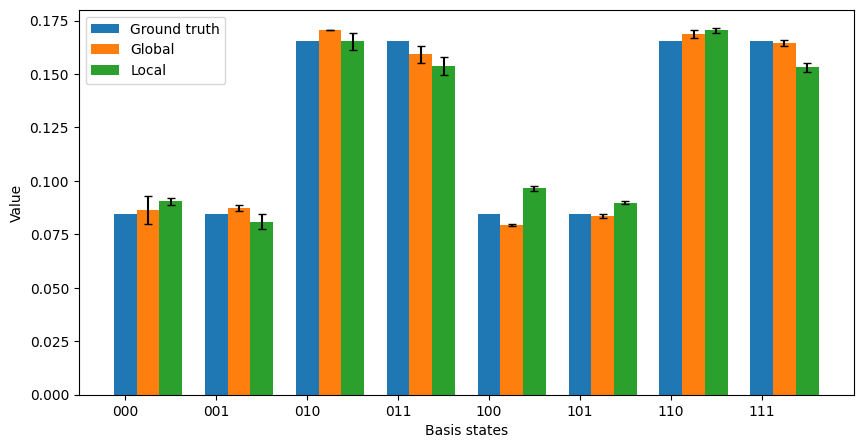

In [5]:
plt.figure(figsize=(10, 5))

x = np.arange(len(normalized_classical_solution)) 
width = 0.25 
multiplier = 0

plt.bar(x, normalized_classical_solution, width = width, label='Ground truth')
plt.bar(x + width, np.mean(global_results, axis=0), yerr=np.std(global_results,axis=0)/np.sqrt(len(local_results)), width=width, capsize=3, label='Global')
plt.bar(x + 2*width, np.mean(local_results, axis=0), yerr=np.std(local_results, axis=0)/np.sqrt(len(local_results)), width=width, capsize=3, label='Local')

plt.legend()
plt.xticks(x, ['000', '001', '010', '011', '100', '101', '110', '111'])
plt.xlabel('Basis states')
plt.ylabel('Value')
plt.show()